# Test cross-domain generalizability
In this section, the proposed model has been tested on the unseen FaceForensics++ dataset. This dataset consists of 1000 original videos that have been manipulated with four facial manipulation methosd such as FaceSwap, NeuralTextures, Face2Face and Deepfakes. As our model is trained on identity swapped videos, the model is first tested against the faceswap dataset of faceforensics++. As a result, the generalizability of the model has been tested on manipulated videos from the first generation, which normally exhibit more visual artifacts (source Dolhansky). Afterwards, the model is tested against other types of facial manipuations, to test the performance of the model on other facial tampared videos. 

As multiple models have been eximanined, the model that have achieved the highest AUC performances on the Celeb-DF test dataset, are tested on generalizability here, which are: 
1. Proposed model 15 frames interval: experiment 10.1
2. Baseline model 15 frames interval: experiment 5.1

In [ ]:
import glob, time, cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.utils import shuffle
from keras import metrics, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CONFIGURATION SETTINGS
# Choose: 'faceswap', 'faceswap_raw', 'deepfakes' , 'deepfakes_raw'
DATASET = 'deepfakes_raw'
BATCH_SIZE = 16
test_models = ['1.1', '2.1', '4.1', '5.1', '6.1', '7.1', '9.1', '10.2']

## 1. Pre-process functions

In [ ]:
def load_test_filepaths(dataset_type):
  # Load the filepaths
  x_real_filenames = [os.path.basename(x[:-4]) for x in glob.glob(f'/path/data_sampled_FF/{dataset_type}/real_hand/*.csv')]
  x_fake_filenames = [os.path.basename(x[:-4]) for x in glob.glob(f'/path/data_sampled_FF/{dataset_type}/fake_hand/*.csv')]

  # Create labels
  y_real = np.ones(len(x_real_filenames))
  y_fake = np.zeros(len(x_fake_filenames))

  # Stack fake and real data
  x_test = x_real_filenames + x_fake_filenames
  y_test = np.hstack((y_real, y_fake))

  # Create y labels and one hot encode them
  y_test = to_categorical(y_test, 2)

  # Shuffle datasets here
  x_test, y_test = shuffle(x_test, y_test, random_state=456)

  print(f'x_test = {len(x_test)}, y_test = {y_test.shape}')
  print(f'x_test = {x_test}')

  return x_test, y_test


def euclidean_distance(point1, point2):
  '''Function that computes the euclidean distance between two 3d points.'''
  return np.sqrt(np.sum((point1-point2)**2, axis=1))

def load_batch_hand(x_batch, y_batch, dataset_type, n_frames, equal_interval=0):
  ''' [Good version TEST] 
  This function loads in all extracted csv files from OpenFace. 
    Input:
      x_batch: filenames of data batch to load in
      y_batch: labels corresponding to x_batch
      n_frames: number of frames per video 
  
    Return: 
      x_batch: numpy array containing all hand-crafted features with shape: (batchsize, features)
  '''
  if equal_interval == 0:
    partial_x = np.zeros((len(x_batch), n_frames, 84), dtype=np.float32)
  else:
    frame_indices = list(range(0, 138, equal_interval)) # Shortest video has 138 frames
    partial_x = np.zeros((len(x_batch), len(frame_indices), 84), dtype=np.float32)

  # Column indexes of hand-crafted features from openface (mouth openness and mouth stretch are added later)
  feature_colindex = [11,12,296,297,298,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695]
  root = f'/path/data_sampled_FF/{dataset_type}/'

  # Loop over all filenames in x_batch_files
  for i, (filename, y) in enumerate(zip(x_batch, y_batch)):
    if y[0] == 1:
      # Load data
      data = np.genfromtxt((root+'fake_hand/'+filename+'.csv'), delimiter=',', skip_header=True)

      # Subselect frames
      if equal_interval == 0:
        data = data[:n_frames, :]
      else:
        data = np.array([data[i] for i in frame_indices])

      try:
        # Define new facial points: mouth openness, mouth stretch, nose features (4). Optional: eye openness of all frames
        uppermouth = data[:, [486, 554, 622]]
        lowermouth = data[:, [492, 560, 628]]
        leftmouthcorner = data[:, [483, 551, 619]]
        rightmouthcorner = data[:, [489, 557, 625]]
        tip_nose = data[:, [465, 533, 601]]

        # Calculate distances
        mouthopenness = euclidean_distance(uppermouth, lowermouth)
        mouthstretch = euclidean_distance(leftmouthcorner, rightmouthcorner)
        nose_leftmouth = euclidean_distance(tip_nose, leftmouthcorner)
        nose_rightmouth = euclidean_distance(tip_nose, rightmouthcorner)
        nose_uppermouth = euclidean_distance(tip_nose, uppermouth)
        nose_lowermouth = euclidean_distance(tip_nose, lowermouth)

        # Only select partial number of frames
        data = data[:, feature_colindex]

        # Add new features to the dataframe
        amplitude = np.column_stack([data, mouthopenness, mouthstretch, nose_leftmouth, nose_rightmouth, nose_uppermouth, nose_lowermouth])

        # Add velocity and acceleration vectors: SHOULD I MAKE ZEROS FOR FIRST FRAMES OR NOT
        amplitude_shifted = np.roll(amplitude, 1, axis=0)
        amplitude_shifted[:1] = 0
        velocity = amplitude_shifted - amplitude
        velocity_shifted = np.roll(velocity, 1, axis=0)
        velocity_shifted[:1] = 0
        acceleration = velocity_shifted - velocity

        f_hand = np.concatenate([amplitude, velocity, acceleration], axis=1)
        partial_x[i] = f_hand

      except Exception as e:
        print('An exception has occurred for csv file: {} with error type: {}'.format(filename, e))

    if y[1] == 1:
      # Search for file in real folder
      data = np.genfromtxt((root+'real_hand/'+filename+'.csv'), delimiter=',', skip_header=True)

      # Subselect frames
      if equal_interval == 0:
        data = data[:n_frames, :]
      else:
        data = np.array([data[i] for i in frame_indices])

      # Then calculate new features
      try:
        # Define new facial points: mouth openness, mouth stretch, nose features (4). Optional: eye openness of all frames
        uppermouth = data[:, [486, 554, 622]]
        lowermouth = data[:, [492, 560, 628]]
        leftmouthcorner = data[:, [483, 551, 619]]
        rightmouthcorner = data[:, [489, 557, 625]]
        tip_nose = data[:, [465, 533, 601]]

        # Calculate distances
        mouthopenness = euclidean_distance(uppermouth, lowermouth)
        mouthstretch = euclidean_distance(leftmouthcorner, rightmouthcorner)
        nose_leftmouth = euclidean_distance(tip_nose, leftmouthcorner)
        nose_rightmouth = euclidean_distance(tip_nose, rightmouthcorner)
        nose_uppermouth = euclidean_distance(tip_nose, uppermouth)
        nose_lowermouth = euclidean_distance(tip_nose, lowermouth)

        # Only select partial number of frames
        data = data[:, feature_colindex]

        # Add new features to the dataframe
        amplitude = np.column_stack([data, mouthopenness, mouthstretch, nose_leftmouth, nose_rightmouth, nose_uppermouth, nose_lowermouth])

        # Add velocity and acceleration vectors: SHOULD I MAKE ZEROS FOR FIRST FRAMES OR NOT
        amplitude_shifted = np.roll(amplitude, 1, axis=0)
        amplitude_shifted[:1] = 0
        velocity = amplitude_shifted - amplitude
        velocity_shifted = np.roll(velocity, 1, axis=0)
        velocity_shifted[:1] = 0
        acceleration = velocity_shifted - velocity

        f_hand = np.concatenate([amplitude, velocity, acceleration], axis=1)
        #print(f'[F_HAND] In total, {f_hand.size - np.count_nonzero(f_hand)} out of {f_hand.size} elements are zero.')

        partial_x[i] = f_hand

      except Exception as e:
        print('An exception has occurred for csv file: {} with error type: {}'.format(filename, e))
  
  # Normalize data to [0,1] interval
  p_min = np.array(partial_x).min()
  p_max = np.array(partial_x).max()
  partial_x = (partial_x - p_min) / (p_max - p_min)
  
  return partial_x

In [ ]:
def generate_frame_names(equal_interval):
  frame_indices = list(range(0, 138, equal_interval))
  frame_names = []

  for i in frame_indices:
    if i <10:
      frame_names.append(f'frame_det_00_00000{i+1}.bmp')

    if i >= 10 and i<100:
      frame_names.append(f'frame_det_00_0000{i+1}.bmp')

    if i >= 100:
      frame_names.append(f'frame_det_00_000{i+1}.bmp')

  return frame_names

In [ ]:
def load_batch_aligned(x_batch, y_batch, dataset_type, n_frames, equal_interval=0):
  '''[Good version] 
  Input:
    * x_batch: filepaths of batch of data 
    * y_batch: labels of data batch
    * n_frames: number of consecutive frames
    * equal_interval: if 0, then first N number of frames are taken, else, equal interval frames is taken

  Output: 
    * partial_x: actual data loaded in based on number of frames
  '''
  # Keras required shape = (batch_size, frames, height, width, channel) and data type numpy
  if equal_interval == 0:
    partial_x = np.zeros((len(x_batch), n_frames, 150, 150, 3), dtype=np.float32)
  else:
    frame_indices = list(range(0, 138, equal_interval)) # Shortest video has 138 frames
    frame_names = generate_frame_names(equal_interval)
    partial_x = np.zeros((len(x_batch), len(frame_indices), 150, 150, 3), dtype=np.float32)

  root = f'/path/data_sampled_FF/{dataset_type}/'

  # Loop over all filepaths in x_batch and load real data
  for i, (filename, y) in enumerate(zip(x_batch, y_batch)):
    try:
      if y[0] == 1:
        path = (root + 'fake_aligned/' + filename + '_aligned')
        
        # Read first n frames, else equal interval
        if equal_interval == 0:

          # Search in fake folder and return frames based on n_frames
          for (d, dirs, files) in os.walk(path):
            frames = [f for f in files if f.endswith('.bmp')][:n_frames]
            for j, frame in enumerate(frames):
              im = cv2.imread(d + '/' + frame)
              #im = cv2.resize(im, (150,150))
              partial_x[i][j] = im

        else:
          # Search in fake folder and return frames based on equal interval
          j = 0
          for frame in [os.path.basename(x) for x in glob.glob(path + '/*.bmp')]:
            if frame in frame_names:
              im = cv2.imread(path + '/' + frame)
              #im = cv2.resize(im, (150,150))
              partial_x[i][j] = im
              j += 1

      elif y[1] == 1:
        path = (root + 'real_aligned/' + filename + '_aligned')

        if equal_interval == 0:
          # Search in fake folder and return all frames of 1 videofile in the batch sorted
          for (d, dirs, files) in os.walk(path):
            frames = [f for f in files if f.endswith('.bmp')][:n_frames]
            for j, frame in enumerate(frames):
              im = cv2.imread(d + '/' + frame)
              #im = cv2.resize(im, (150,150))
              partial_x[i][j] = im

        else:
          # Search in fake folder and return frames based on equal interval
          j = 0
          for frame in [os.path.basename(x) for x in glob.glob(path + '/*.bmp')]:
            if frame in frame_names:
              im = cv2.imread(path + '/' + frame)
              #im = cv2.resize(im, (150,150))
              partial_x[i][j] = im
              j += 1

    except Exception as e:
      print('An exception has occurred for algined file: {} with error type: {}'.format(filename, e))

  # Normalize the whole batch at once
  partial_x /= 255.0

  return partial_x

In [ ]:
def evaluate_model(model, x_test, y_test, batch_size, dataset_type, n_frames=5, equal_interval=0, experiment='test'):
  start_time = time.time()

  # Define evaluation metrics
  test_acc_metric = metrics.CategoricalAccuracy()
  test_auc_metric = metrics.AUC()

  # Create indices of x_test list to loop over
  test_batch_indices = list(range(len(x_test)//batch_size))
  predictions = []
  probas = []

  ##### TEST LOOP #####
  for b_idx in test_batch_indices:
    # Create test batch
    batch_start = b_idx * batch_size
    batch_end = (b_idx + 1) * batch_size
    x_batch_test_filenames = x_test[batch_start : batch_end]
    y_batch_test = y_test[batch_start : batch_end]
    
    # Load test data for batch
    if experiment in ['6.1', '7.1', '9.1', '10.2']:
      x_batch_test_hand = load_batch_hand(x_batch_test_filenames, y_batch_test, dataset_type=dataset_type, n_frames=n_frames, equal_interval=equal_interval)
      x_batch_test_aligned = load_batch_aligned(x_batch_test_filenames, y_batch_test, dataset_type=dataset_type, n_frames=n_frames, equal_interval=equal_interval)
      y_prob = model([x_batch_test_hand, x_batch_test_aligned], training=False)

    if experiment in ['1.1', '2.1', '4.1', '5.1']:
      x_batch_test_aligned = load_batch_aligned(x_batch_test_filenames, y_batch_test, dataset_type=dataset_type, n_frames=n_frames, equal_interval=equal_interval)
      y_prob = model(x_batch_test_aligned, training=False)

    if experiment in ['11.1', '12.1']:
      x_batch_test_hand = load_batch_hand(x_batch_test_filenames, y_batch_test, dataset_type=dataset_type, n_frames=n_frames, equal_interval=equal_interval)
      y_prob = model(x_batch_test_hand, training=False)

    # Compute predictions and update metrics
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_batch_test, axis=1)
    probas.append(y_prob)
    predictions.append(y_pred)
    test_acc_metric.update_state(y_batch_test, y_prob)
    test_auc_metric.update_state(y_batch_test, y_prob)

    print(f'[INFO] {b_idx+1} / {len(test_batch_indices)}')

  test_acc = round(test_acc_metric.result().numpy(), 3)
  test_auc = round(test_auc_metric.result().numpy(), 3)

  # Calculate confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.array(predictions).flatten())
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]

  print('Confusion matrix')
  print(cm)

  # Calculate false postive rates and true positive rates
  probas = np.array(probas).reshape(len(x_test), 2)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test[:, 1], probas)

  print()
  print('Accuracy: {:.3f}'.format(test_acc))
  print('AUC: {:.3f}'.format(test_auc))

  print('Correctly Detected Deepfakes (True Negatives): ', tn)
  print('Deepfake Videos Incorrectly Detected (False Positives): ', fp)
  print('Deepfake Videos Missed (False Negatives): ', fn)
  print('Deepfake Videos Detected (True Positives): ', tp)
  print('Total Deepfake Videos: ', tn+fp+fn+tp)
  print()
  print('Time taken: {:.4f} seconds'.format((time.time() - start_time)))
  print('-----------------------------------------------')
  print()

  return test_acc, test_auc, predictions, tp, fp, tn, fn, fpr, tpr, cm

## 2. Evaluation code

In [ ]:
# Load data
x_test, y_test = load_test_filepaths(dataset_type=DATASET)

In [ ]:
# Evaluate all models
for EXPERIMENT in test_models:
  model = models.load_model(f'/path/tmp/results_ex{EXPERIMENT}_model.h5')
  print(f'Loaded model: {EXPERIMENT}')

  # Evaluate models
  if EXPERIMENT == '1.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 0
    acc_1, auc_1, pred_1, tp_1, fp_1, tn_1, fn_1, fpr_1, tpr_1, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '2.1':
    N_FRAMES = 20
    EQUAL_INTERVAL = 0
    acc_2, auc_2, pred_2, tp_2, fp_2, tn_2, fn_2, fpr_2, tpr_2, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '4.1':
    N_FRAMES = 5
    EQUAL_INTERVAL = 30
    acc_4, auc_4, pred_4, tp_4, fp_4, tn_4, fn_4, fpr_4, tpr_4, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '5.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 15
    acc_5, auc_5, pred_5, tp_5, fp_5, tn_5, fn_5, fpr_5, tpr_5, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '6.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 0
    acc_6, auc_6, pred_6, tp_6, fp_6, tn_6, fn_6, fpr_6, tpr_6, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '7.1':
    N_FRAMES = 20
    EQUAL_INTERVAL = 0
    acc_7, auc_7, pred_7, tp_7, fp_7, tn_7, fn_7, fpr_7, tpr_7, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '9.1':
    N_FRAMES = 5
    EQUAL_INTERVAL = 30
    acc_9, auc_9, pred_9, tp_9, fp_9, tn_9, fn_9, fpr_9, tpr_9, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

  if EXPERIMENT == '10.2':
    N_FRAMES = 10
    EQUAL_INTERVAL = 15
    acc_10, auc_10, pred_10, tp_10, fp_10, tn_10, fn_10, fpr_10, tpr_10, cm = evaluate_model(model, x_test, y_test, dataset_type=DATASET, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

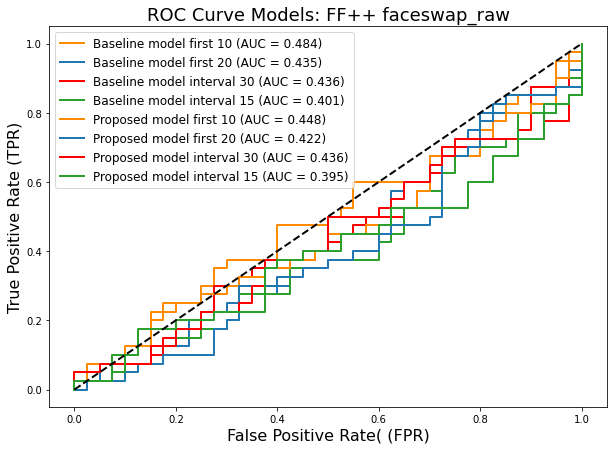

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(fpr_1, tpr_1, label='Baseline model first 10 (AUC = {:.3f})'.format(auc_1), linewidth=2, color='darkorange')
plt.plot(fpr_2, tpr_2, label='Baseline model first 20 (AUC = {:.3f})'.format(auc_2), linewidth=2, color='tab:blue')
plt.plot(fpr_4, tpr_4, label='Baseline model interval 30 (AUC = {:.3f})'.format(auc_4), linewidth=2, color='red')
plt.plot(fpr_5, tpr_5, label='Baseline model interval 15 (AUC = {:.3f})'.format(auc_5), linewidth=2, color='tab:green')
plt.plot(fpr_6, tpr_6, label='Proposed model first 10 (AUC = {:.3f})'.format(auc_6), linewidth=2, color='darkorange')
plt.plot(fpr_7, tpr_7, label='Proposed model first 20 (AUC = {:.3f})'.format(auc_7), linewidth=2, color='tab:blue')
plt.plot(fpr_9, tpr_9, label='Proposed model interval 30 (AUC = {:.3f})'.format(auc_9), linewidth=2, color='red')
plt.plot(fpr_10, tpr_10, label='Proposed model interval 15 (AUC = {:.3f})'.format(auc_10), linewidth=2, color='tab:green')
plt.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        linestyle='--', linewidth=2, color='black')
plt.title(f'ROC Curve Models: FF++ {DATASET}', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.xlabel('False Positive Rate( (FPR)', fontsize=16)
plt.legend(fontsize=12)
plt.savefig(f'path/AUC_plot_test{DATASET}')
plt.show()